In [2]:
import os
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras import backend as K
K.clear_session()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

from scipy import signal
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
from tensorflow.keras import backend as K
K.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def read_data(data_folder, num_files=None):
    """
    Read EEG and spectrogram data from Parquet files in the specified data folder.

    Parameters:
    - data_folder (str): Path to the main data folder containing 'train' and 'test' subfolders.
    - num_files (int or None): Number of files to read from each subfolder. If None, all files will be read.

    Returns:
    - train (List[Tuple[pd.DataFrame, pd.DataFrame]]): List of tuples containing train EEG data and train spectrogram data.
    - test (List[Tuple[pd.DataFrame, pd.DataFrame]]): List of tuples containing test EEG data and test spectrogram data.
    - train_labels (pd.DataFrame): DataFrame containing train labels.
    - test_labels (pd.DataFrame): DataFrame containing test labels.
    """
    train_eeg_folder = os.path.join(data_folder, 'train_eegs')
    test_eeg_folder = os.path.join(data_folder, 'test_eegs')
    train_spectrograms_folder = os.path.join(data_folder, 'train_spectrograms')
    test_spectrograms_folder = os.path.join(data_folder, 'test_spectrograms')

    def read_parquet_folder(folder_path, n_files=None):
        dataframes = []
        files_to_read = os.listdir(folder_path)[:n_files] if n_files else os.listdir(folder_path)
        for file in files_to_read:
            if file.endswith('.parquet'):
                file_path = os.path.join(folder_path, file)
                dataframe = pq.read_table(file_path).to_pandas()
                dataframes.append(dataframe)
        print(f"Read {len(dataframes)} files from {folder_path}.")
        return dataframes


    # Read EEG data
    train_eeg = read_parquet_folder(train_eeg_folder, num_files)
    test_eeg = read_parquet_folder(test_eeg_folder)

    # Read spectrogram data
    train_spectrograms = read_parquet_folder(train_spectrograms_folder, num_files)
    test_spectrograms = read_parquet_folder(test_spectrograms_folder)

    # Interpolate NaN values
    train_eeg = [df.fillna(df.mean()) for df in train_eeg]
    train_spectrograms = [df.fillna(df.mean()) for df in train_spectrograms]



    # Check nan values
    print("NaN values in train_eeg:", any(df.isnull().any().any() for df in train_eeg))
    print("NaN values in train_spectrograms:", any(df.isnull().any().any() for df in train_spectrograms))
    print("NaN values in test_eeg:", any(df.isnull().any().any() for df in test_eeg))
    print("NaN values in test_spectrograms:", any(df.isnull().any().any() for df in test_spectrograms))

    # Combine data into tuples
    train_data = [(eeg, spec) for eeg, spec in zip(train_eeg, train_spectrograms)]
    test_data = [(eeg, spec) for eeg, spec in zip(test_eeg, test_spectrograms)]

    train_labels = pd.read_csv('train.csv',nrows=num_files)
    test_labels = pd.read_csv('test.csv')


    return train_data, test_data, train_labels, test_labels

In [4]:
def single_vis(f, visualization_type):
    """
    Visualize single EEG channels or Spectrogram from the provided DataFrame.

    Parameters:
    - f (pd.DataFrame): The DataFrame containing the data to be visualized.
    - visualization_type (str): Specify the type of visualization: 'eeg' for EEG channels or 'spectrogram' for Spectrogram.

    Raises:
    - ValueError: If an invalid `visualization_type` is provided.

    Returns:
    None
    """
    
    if visualization_type == 'eeg':
        channels_to_exclude = []
        title = 'EEG Channels Visualization'
        
        eeg_channels = [column for column in f.columns if column not in channels_to_exclude]
        plt.figure(figsize=(40, 10))
        
        # Calculate the offset for each channel based on the maximum amplitude
        max_amplitude = f[eeg_channels].max().max()
        channel_offset = max_amplitude * 1.2  # Adjust the multiplier as needed
        
        for i, column in enumerate(eeg_channels):
            y_values = f[column] + i * channel_offset
            plt.plot(f.index, y_values, label=column)

        plt.title(title)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()
        
    elif visualization_type == 'spectrogram':
        channels_to_exclude = ['time']
        title = 'Spectrogram Visualization'
        
        spectrogram_channels = [column for column in f.columns if column not in channels_to_exclude]
        plt.figure(figsize=(40, 10))
        
        combined_spectrogram = np.zeros((len(f), len(spectrogram_channels)))
        for i, column in enumerate(spectrogram_channels):
            combined_spectrogram[:, i] = f[column].values
        
        plt.imshow(combined_spectrogram.T, aspect='auto', cmap='viridis', interpolation='nearest')
        plt.title(title)
        plt.xlabel('Sample')
        plt.ylabel('Channel')
        plt.show()
        
    else:
        raise ValueError("Invalid visualization type. Use 'eeg' or 'spectrogram'.")


In [5]:
desired_length = 100
num_features = 32
desired_length = 100  
num_frequency_bins = 32  
num_classes = 6 

In [6]:

def preprocess_eeg(X_train_eeg, target_shape=(desired_length, num_features)):
    eeg_array = np.array(X_train_eeg)[:desired_length, :num_features].astype(np.float32)
    return eeg_array



def preprocess_spectrogram(spectrogram_df, target_shape=(desired_length, num_frequency_bins)):
    spec_array = np.array(spectrogram_df)[:target_shape[0], :target_shape[1]].astype(np.float32)
    return spec_array

def create_model(input_shape_eeg, input_shape_spectrogram, num_classes=6):
    """Create a multi-input, multi-output model for
    EEG and Spectrogram data.

    Args:
        input_shape_eeg : shape of one EEG sample
        input_shape_spectrogram : shape of one Spectrogram sample
        num_classes : 6 for seizure, lpd, gpd, lrda, grda, other

    Returns:
        keras model
    """
    
    # EEG branch
    input_eeg = Input(shape=input_shape_eeg, name='input_eeg')
    eeg_features = Flatten()(input_eeg)
    eeg_features = Dense(64, activation='relu')(eeg_features)
    eeg_features = BatchNormalization(momentum=0.9, epsilon=1e-5)(eeg_features)
    eeg_features = Dropout(0.4)(eeg_features)

    # Spectrogram branch
    input_spectrogram = Input(shape=input_shape_spectrogram, name='input_spectrogram')
    spec_features = Flatten()(input_spectrogram)
    spec_features = Dense(64, activation='relu')(spec_features)
    spec_features = BatchNormalization(momentum=0.9, epsilon=1e-5)(spec_features)
    spec_features = Dropout(0.4)(spec_features)

    concatenated_features = Concatenate()([eeg_features, spec_features])

    x = Dense(128, activation='relu')(concatenated_features)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Dropout(0.4)(x)

    output_layer = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[input_eeg, input_spectrogram], outputs=output_layer)
    return model

def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.9
    return lr

In [7]:
train,test,train_labels,test_labels = read_data('data',100)

Read 100 files from data/train_eegs.
Read 1 files from data/test_eegs.
Read 100 files from data/train_spectrograms.
Read 1 files from data/test_spectrograms.
NaN values in train_eeg: False
NaN values in train_spectrograms: False
NaN values in test_eeg: False
NaN values in test_spectrograms: False


In [8]:
train_features = [(eeg, spec) for eeg, spec in train]
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42,shuffle=True)

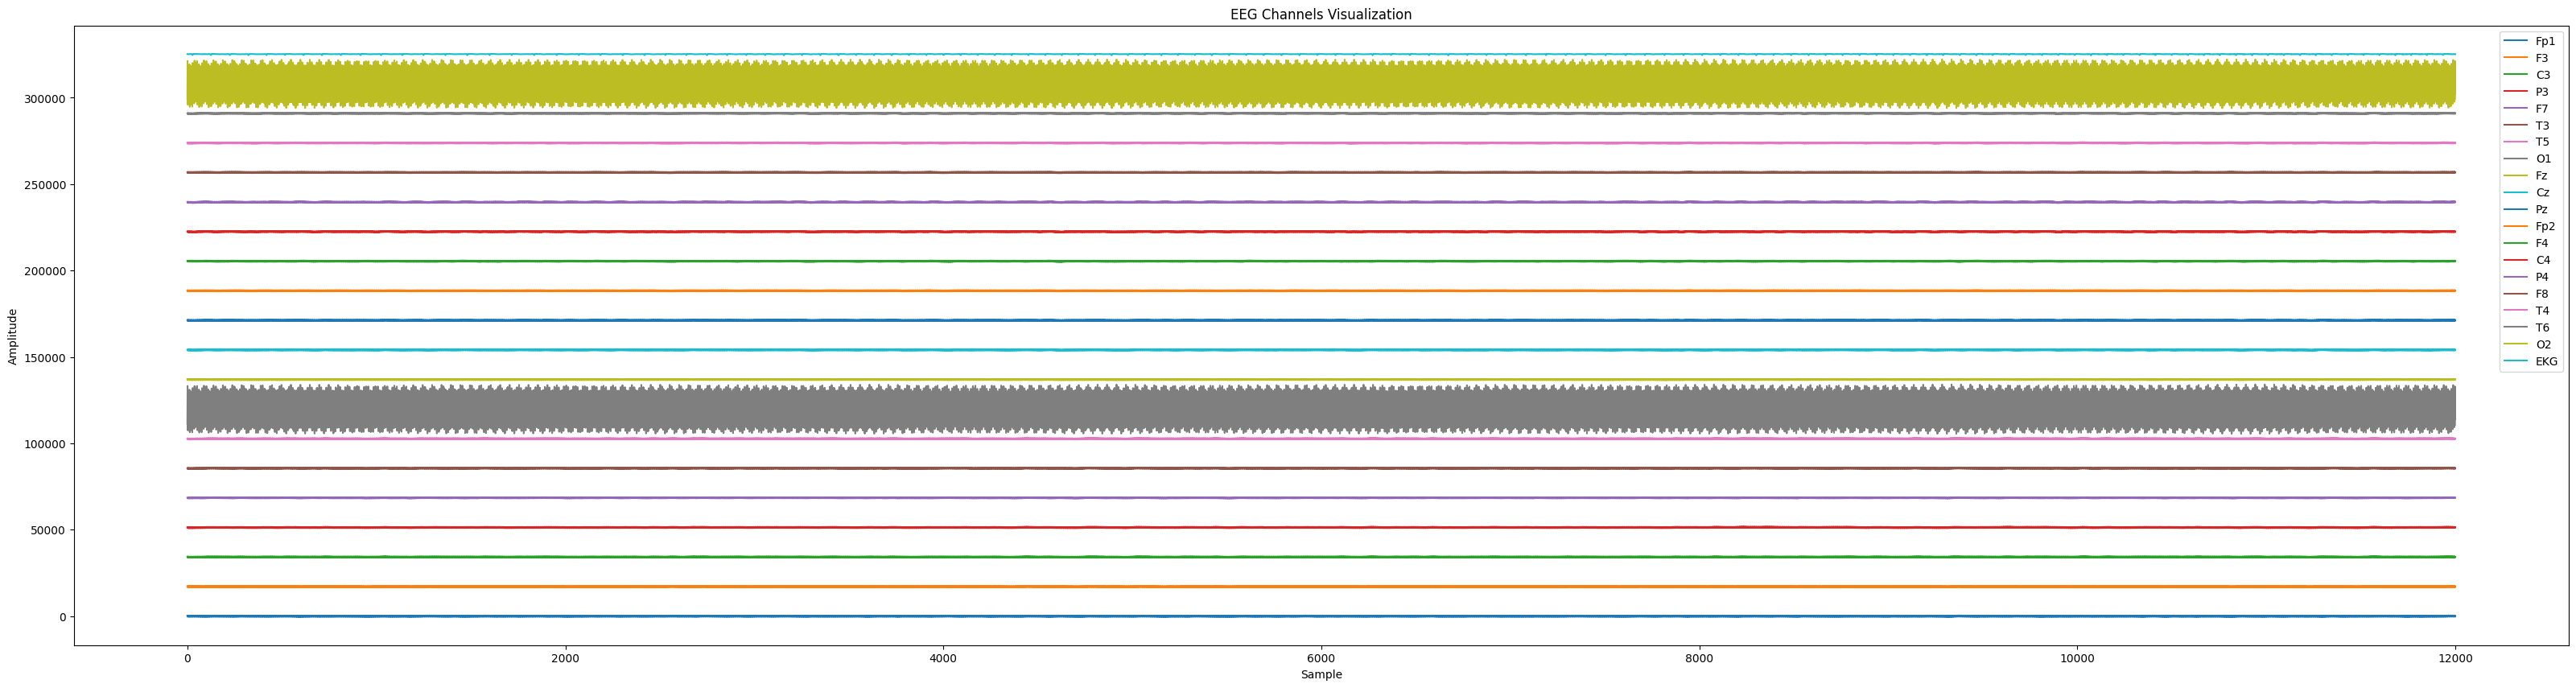

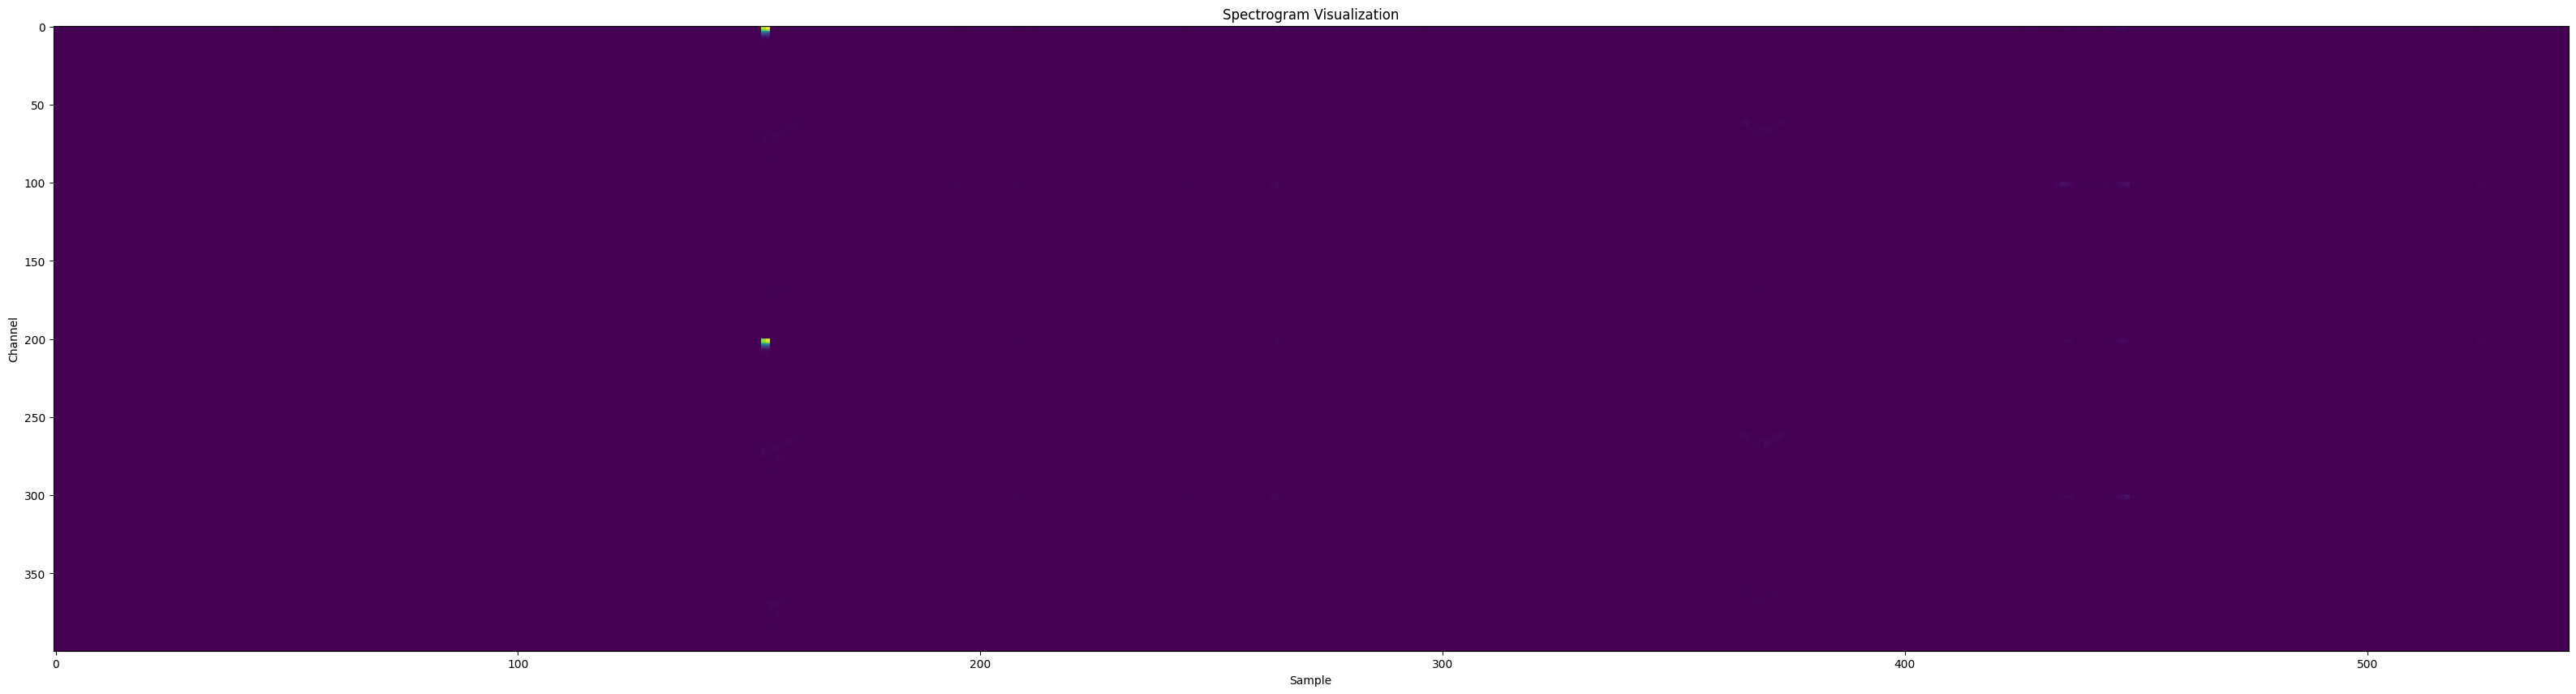

In [9]:
single_vis(X_train[1][0], 'eeg')
single_vis(X_train[1][1], 'spectrogram')

In [10]:
y_train = np.array(y_train)

In [11]:
labels = y_train[:, 8]

# Encoding labels using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert labels to categorical one-hot encoding
one_hot_labels = to_categorical(encoded_labels, num_classes=num_classes)

# Convert labels to float32
y_train = one_hot_labels.astype('float32')

# Convert other columns to numeric values
for col_index in range(y_train.shape[1]):
    # Skip label column as it has already been encoded
    if col_index == 8:
        continue
    
    # Convert each element in the column to a numeric value
    y_train[:, col_index] = np.array([float(val) if isinstance(val, str) and '.' in val else int(val) for val in y_train[:, col_index]])


In [12]:
y_train

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0.

In [13]:
X_train_eeg = np.array([preprocess_eeg(item[0]) for item in X_train]).astype(np.float32)
X_train_spectrogram = np.array([preprocess_spectrogram(item[1]) for item in X_train]).astype(np.float32)
X_train_spectrogram = np.nan_to_num(X_train_spectrogram)


# Define input shapes
input_shape_eeg = X_train_eeg.shape[1:]  # Shape of one EEG sample
input_shape_spectrogram = X_train_spectrogram.shape[1:]  # Shape of one Spectrogram sample
num_classes = y_train.shape[1] 

In [14]:
input_shape_eeg[0]

100

In [15]:
for i in range(len(X_train_eeg)):
    if np.any(np.isnan(X_train_eeg[i])):
        print(i)

In [16]:
print(X_train_eeg[14])

[[-1.5484e+02 -1.2795e+02 -4.8440e+01 ... -2.8970e+01  3.5200e+00
   9.7150e+01]
 [-1.9673e+02 -1.5976e+02 -7.3180e+01 ... -6.0180e+01 -2.0760e+01
   5.8900e+01]
 [-2.2130e+02 -1.8062e+02 -8.7400e+01 ... -7.6210e+01 -3.5180e+01
   1.1640e+01]
 ...
 [-6.5470e+01 -7.4230e+01 -8.8400e+00 ...  6.8000e-01 -9.0000e-02
   3.8300e+01]
 [-9.3040e+01 -1.0544e+02 -5.0530e+01 ... -2.2830e+01 -3.5780e+01
   7.0730e+01]
 [-1.4016e+02 -1.4613e+02 -1.0874e+02 ... -8.5020e+01 -8.0120e+01
  -2.6300e+00]]


In [17]:
print(X_train_eeg.dtype)
print(X_train_spectrogram.dtype)
print(y_train.dtype)
print(input_shape_eeg[1:])
print(input_shape_spectrogram[1:])
print(np.any(np.isnan(X_train_eeg)))
print(np.any(np.isnan(X_train_spectrogram)))
print(np.any(np.isinf(X_train_eeg)))
print(np.any(np.isinf(X_train_spectrogram)))

float32
float32
float32
(20,)
(32,)
False
False
False
False


In [18]:
model = create_model(input_shape_eeg, input_shape_spectrogram, num_classes)
optimizer = Adam(learning_rate=0.001)
lr_scheduler = LearningRateScheduler(lr_schedule)

model.compile(optimizer=optimizer, loss = tf.keras.losses.KLDivergence(), metrics=['accuracy'])

model.fit([X_train_eeg, X_train_spectrogram], y_train, epochs=100, batch_size=32)


2024-01-29 18:53:20.690481: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-29 18:53:20.690783: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-29 18:53:20.691013: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/100


2024-01-29 18:53:22.061309: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-29 18:53:23.223426: I external/local_xla/xla/service/service.cc:168] XLA service 0x7866814311a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-29 18:53:23.223449: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-01-29 18:53:23.227129: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-29 18:53:23.241236: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1706534603.321536  346718 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 [==============================] - 3s 8ms/step - loss: 2.8309 - accuracy: 0.1875
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 2.6560 - accuracy: 0.1375
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 2.0501 - accuracy: 0.2625
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 2.2369 - accuracy: 0.2750
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 1.6800 - accuracy: 0.3500
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 1.9249 - accuracy: 0.3000
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 1.6304 - accuracy: 0.3250
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 1.6194 - accuracy: 0.4250
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 1.6571 - accuracy: 0.4250
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 1.5082 - accuracy: 0.4625
Epoch 11/100
3/3 [=======================

KeyboardInterrupt: 

In [ ]:
model.summary()

In [ ]:
X_test_eeg = np.array([preprocess_eeg(item[0]) for item in X_test])
X_test_spectrogram = np.array([preprocess_spectrogram(item[1]) for item in X_test])
y_pred = model.predict([X_test_eeg, X_test_spectrogram])

eeg_ids_test = [X_test[i][0].index[0] for i in range(len(X_test))]

output_df = pd.DataFrame({
    'eeg_id': eeg_ids_test,
    'seizure_vote': y_pred[:, 0],
    'lpd_vote': y_pred[:, 1],
    'gpd_vote': y_pred[:, 2],
    'lrda_vote': y_pred[:, 3],
    'grda_vote': y_pred[:, 4],
    'other_vote': y_pred[:, 5]
})


In [ ]:
output_df

In [ ]:
output_df['predicted_class'] = output_df.iloc[:, 1:].idxmax(axis=1)

In [ ]:
print(output_df[['eeg_id', 'predicted_class']])

In [ ]:
print("Shape of X_test_eeg:", X_test_eeg.shape)
print("Shape of X_test_spectrogram:", X_test_spectrogram.shape)
print("NaN values in X_test_eeg:", np.isnan(X_test_eeg).any())
print("NaN values in X_test_spectrogram:", np.isnan(X_test_spectrogram).any())


In [ ]:
y_test = np.array(y_test)
labelst = y_test[:, 8]

# Encoding labels using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labelst)

# Convert labels to categorical one-hot encoding
one_hot_labels = to_categorical(encoded_labels, num_classes=num_classes)

# Convert labels to float32
y_test = one_hot_labels.astype('float32')

# Convert other columns to numeric values
for col_index in range(y_test.shape[1]):
    # Skip label column as it has already been encoded
    if col_index == 8:
        continue
    
    # Convert each element in the column to a numeric value
    y_test[:, col_index] = np.array([float(val) if isinstance(val, str) and '.' in val else int(val) for val in y_test[:, col_index]])


In [ ]:
test_loss, test_accuracy = model.evaluate([X_test_eeg, X_test_spectrogram], y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
